In [83]:
# Names and EID:
# Matthew Pham (map7578)
# Thai
# Jack
# Issay

# Data Cleaning/Exploration, Feature Engineering

Our first strategy to figure out how to clean the data was to simply look at it in an excel spreadsheet. 
Here are some things we noticed:
* Lots of the categories are non-numerical (breed, climate zone, management system, date, etc.)
* lots of numerical values start with a "'"
* Some negative values don't make sense (rumination time)
* Some blank values
* Feed quantity is present twice

In [84]:
# imports 

import pandas as pd 
import sklearn 
import matplotlib as plt

In [85]:
# read in the data
data = pd.read_csv("cattle_data_train.csv")
test = pd.read_csv("cattle_data_test.csv")
labels = data.iloc()[:, -1]

data.head()

,Cattle_ID,Breed,Climate_Zone,Management_System,Age_Months,Weight_kg,Parity,Lactation_Stage,Days_in_Milk,Feed_Type,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Rumination_Time_hrs,Resting_Hours,Ambient_Temperature_C,Humidity_percent,Housing_Score,FMD_Vaccine,Brucellosis_Vaccine,HS_Vaccine,BQ_Vaccine,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Date,Farm_ID,Feed_Quantity_lb,Mastitis,Milk_Yield_L
0,CATTLE_133713,Holstein,Tropical,Intensive,114,544.8,4,Mid,62,Concentrates,16.363455,2,71.101024,4.77,7.8,-2.269369,12.3,28.706090,70.6,0.871430,0,1,1,0,0,1,0,1,6.31,3.0,12,2024-01-15,FARM_0301,36.8235,1,12.192634
1,CATTLE_027003,Holstein,Arid,Mixed,136,298.9,4,Mid,213,Crop_Residues,NaN,4,55.697328,5.99,7.4,8.973851,11.4,28.599741,57.5,0.825488,1,1,0,1,0,0,0,0,17.16,4.0,12,2023-10-31,FARM_0219,NaN,0,14.717031
2,CATTLE_122459,Holstein,Tropical,Semi_Intensive,64,336.6,4,Late,16,Hay,7.198607,2,65.576827,3.45,8.8,-4.590550,8.6,12.520386,51.2,0.904957,0,0,1,1,0,1,1,0,4.07,3.5,12,2024-05-20,FARM_0802,16.0965,0,14.006142
3,CATTLE_213419,Jersey,Mediterranean,Intensive,58,370.5,1,Early,339,Crop_Residues,18.694344,2,71.238287,5.95,6.5,1.792698,10.1,40.510261,57.9,0.324955,1,0,1,0,1,0,0,0,10.23,3.0,24,2024-07-22,FARM_0034,40.7925,0,24.324325
4,CATTLE_106260,Guernsey,Subtropical,Intensive,84,641.5,6,Early,125,Mixed_Feed,14.779198,4,46.979548,5.39,6.4,12.621422,9.3,-7.711288,73.2,0.871019,0,1,1,1,1,0,1,1,20.68,3.0,12,2023-01-03,FARM_0695,33.7365,1,12.023074


In [86]:
# checking which columns have missing values
data.isna().sum()

Cattle_ID                      0
Breed                          0
Climate_Zone                   0
Management_System              0
Age_Months                     0
Weight_kg                      0
Parity                         0
Lactation_Stage                0
Days_in_Milk                   0
Feed_Type                      0
Feed_Quantity_kg           10481
Feeding_Frequency              0
Water_Intake_L                 0
Walking_Distance_km            0
Grazing_Duration_hrs           0
Rumination_Time_hrs            0
Resting_Hours                  0
Ambient_Temperature_C          0
Humidity_percent               0
Housing_Score               6279
FMD_Vaccine                    0
Brucellosis_Vaccine            0
HS_Vaccine                     0
BQ_Vaccine                     0
Anthrax_Vaccine                0
IBR_Vaccine                    0
BVD_Vaccine                    0
Rabies_Vaccine                 0
Previous_Week_Avg_Yield        0
Body_Condition_Score           0
Milking_In

In [87]:
# Number of unique values in each column

# data.apply(lambda s: s.duplicated().sum())
data.apply(lambda s: s.value_counts().gt(1).sum())
print(data["Breed"].unique()) # found that some names are wrong for the cows
data["Breed"] = data["Breed"].replace("Holstien", "Holstein")
data["Breed"] = data["Breed"].str.strip()
print(data.head())


['Holstein' 'Jersey' 'Guernsey' 'Brown Swiss' ' Brown Swiss' 'Holstien'
 'Brown Swiss ']
       Cattle_ID     Breed   Climate_Zone Management_System  Age_Months  \
0  CATTLE_133713  Holstein       Tropical         Intensive         114   
1  CATTLE_027003  Holstein           Arid             Mixed         136   
2  CATTLE_122459  Holstein       Tropical    Semi_Intensive          64   
3  CATTLE_213419    Jersey  Mediterranean         Intensive          58   
4  CATTLE_106260  Guernsey    Subtropical         Intensive          84   

   Weight_kg  Parity Lactation_Stage  Days_in_Milk      Feed_Type  \
0      544.8       4             Mid            62   Concentrates   
1      298.9       4             Mid           213  Crop_Residues   
2      336.6       4            Late            16            Hay   
3      370.5       1           Early           339  Crop_Residues   
4      641.5       6           Early           125     Mixed_Feed   

   Feed_Quantity_kg  Feeding_Frequency  Water

In [88]:
# We are considering how to impute the missing values for housing score and feed amount.
# One thought was that maybe all the cows from one farm are missing a housing score/feed amount. 
# We found here that that is not the case, as the max missing from any given 
# farm is 22 for either one. We now explore using the mean housing score or feed amount from a given 
# farm to impute missing values. Intuitively, both of these make sense, however, we 
# find that while, within farms, housing score varies very little (VAR: 0.04100923726054576)
# while feed amount varies a lot: (VAR: 15.74869934892377). 
# Unfortunately, we found that the variances across the entire data set (15.754920313482826, 0.04101214069288791)
# are very similar, as were the means, generally, so it would not help very much
# to impute with the mean of the farms. 


max_missing = -1
total_housing_var = 0
total_feed_var = 0

for name, group in data.groupby("Farm_ID"):
    # Missing counts
    missing_housing = group["Housing_Score"].isna().sum()
    missing_feed = group["Feed_Quantity_kg"].isna().sum()
    
    total = len(group)

    # Track max missing across the two columns
    max_missing = max(max_missing, missing_housing, missing_feed)

    # Only print groups with any missing values
    if missing_housing > 0 or missing_feed > 0:

        # Variances (skip NaN automatically)
        housing_var = group["Housing_Score"].var()
        feed_var = group["Feed_Quantity_kg"].var()
        housing_mean = group["Housing_Score"].mean()
        feed_mean = group["Feed_Quantity_kg"].mean()

        total_housing_var += housing_var
        total_feed_var += feed_var

        print(f"Group: {name}")
        print(f"  Missing Housing_Score:     {missing_housing}")
        print(f"  Missing Feed_Quantity_kg:  {missing_feed}")
        print(f"  Total in group:            {total}")

        print(f"  Housing_Score variance:    {housing_var}")
        print(f"  Feed_Quantity_kg variance: {feed_var}\n")
        print(f"  Housing_Score mean:    {housing_mean}")
        print(f"  Feed_Quantity_kg mean: {feed_mean}\n")


average_feed_var = total_feed_var / 1000
average_housing_var = total_housing_var / 1000 

whole_data_feed_var = data["Feed_Quantity_kg"].var()
whole_data_housing_var = data["Housing_Score"].var()

print("whole data feed var: " + str(whole_data_feed_var))
print("whole data housing var: " + str(whole_data_housing_var))
print("average feed var: " + str(average_feed_var) + "\naverage housing var: " + str(average_housing_var))
print("max missing from any given farm: " + str(max_missing))

Group: FARM_0001
  Missing Housing_Score:     7
  Missing Feed_Quantity_kg:  13
  Total in group:            199
  Housing_Score variance:    0.04217811540431952
  Feed_Quantity_kg variance: 15.355051079652647

  Housing_Score mean:    0.6506222698428817
  Feed_Quantity_kg mean: 12.346106829669043

Group: FARM_0002
  Missing Housing_Score:     4
  Missing Feed_Quantity_kg:  10
  Total in group:            200
  Housing_Score variance:    0.04123126975618914
  Feed_Quantity_kg variance: 17.112276135559075

  Housing_Score mean:    0.6765135181913958
  Feed_Quantity_kg mean: 12.06853684385468

Group: FARM_0003
  Missing Housing_Score:     7
  Missing Feed_Quantity_kg:  11
  Total in group:            204
  Housing_Score variance:    0.040416164955278756
  Feed_Quantity_kg variance: 15.307978398294097

  Housing_Score mean:    0.6281224369763271
  Feed_Quantity_kg mean: 12.362122895737603

Group: FARM_0004
  Missing Housing_Score:     5
  Missing Feed_Quantity_kg:  15
  Total in group:   

                         Age_Months  Weight_kg    Parity  Days_in_Milk  \
Age_Months                 1.000000   0.002184  0.001056      0.001971   
Weight_kg                  0.002184   1.000000  0.001573      0.002310   
Parity                     0.001056   0.001573  1.000000     -0.001991   
Days_in_Milk               0.001971   0.002310 -0.001991      1.000000   
Feed_Quantity_kg           0.000363  -0.002157  0.004293      0.001656   
Feeding_Frequency          0.000667   0.000598  0.001102     -0.000614   
Water_Intake_L            -0.001321   0.000361  0.001955     -0.000763   
Walking_Distance_km        0.000282  -0.000720  0.002175     -0.001460   
Grazing_Duration_hrs       0.001701   0.002364 -0.006114      0.003911   
Resting_Hours              0.002786   0.001438  0.000022      0.001355   
Ambient_Temperature_C     -0.002812  -0.000681 -0.001248      0.002559   
Humidity_percent          -0.003242  -0.001921  0.002122     -0.002089   
Housing_Score             -0.000462  -

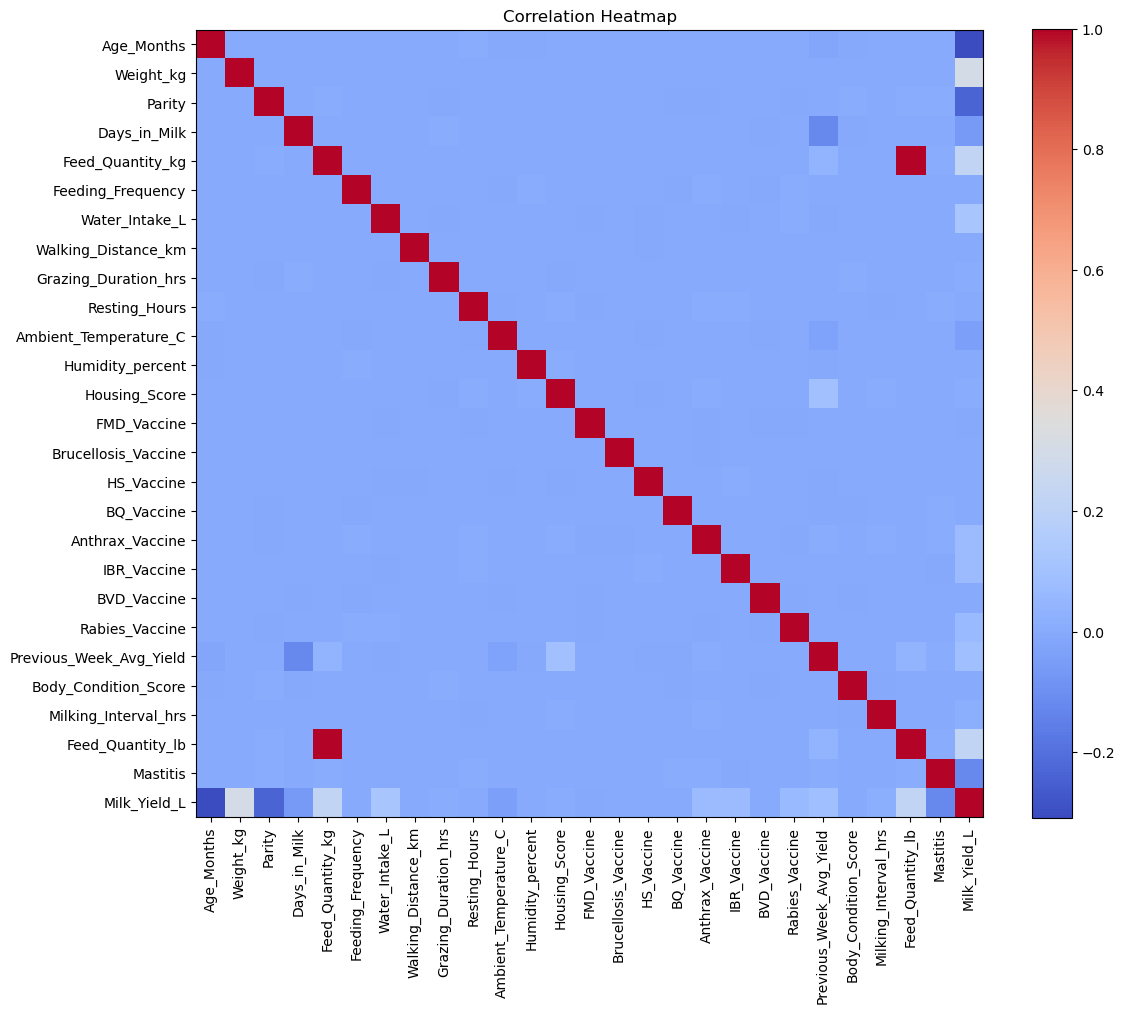

In [89]:

# Here we see that the correlation between housing quality and feed amount
# and all other data is quite low, meaning this would be a poor way to impute the data. 

# we do, however, find that the correlation between Rumination_Time_hrs and Previous_Week_Avg_Yield
# is 1 to 1. This means we can drop one of them and lose no information our model might use. 

data = data.drop(columns=['Rumination_Time_hrs'])


# Select only numeric columns (automatically ignores text columns)
numeric_cols = data.select_dtypes(include=['number'])
numeric_cols = data.select_dtypes(include='number')

# Full correlation matrix
corr_matrix = numeric_cols.corr()

# Print it as a table
print(corr_matrix)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [90]:
from sklearn.impute import KNNImputer

# Since housing score varies little within farms (VAR: 0.041 within farms vs 0.041 overall),
# we can use farm-level imputation for Housing_Score.
# For Feed_Quantity_kg, high variance within farms (VAR: 15.75) suggests KNN imputation
# based on similar cows (age, weight, parity) would be better.

data_imputed = data.copy()

# Track which values were imputed
data_imputed["housing_imputed"] = data_imputed["Housing_Score"].isna().astype(int)
data_imputed["feed_imputed"] = data_imputed["Feed_Quantity_kg"].isna().astype(int)

# Calculate farm-level medians
farm_housing_median = data_imputed.groupby('Farm_ID')['Housing_Score'].transform('median')

# Fill missing values with farm median
data_imputed['Housing_Score'] = data_imputed['Housing_Score'].fillna(farm_housing_median)

# If any still missing (entire farm missing), use global median
global_housing_median = data_imputed['Housing_Score'].median()
data_imputed['Housing_Score'] = data_imputed['Housing_Score'].fillna(global_housing_median)

# Select features that predict feed quantity
knn_features = ['Age_Months', 'Weight_kg', 'Parity', 'Days_in_Milk', 
                'Water_Intake_L', 'Body_Condition_Score', 'Feed_Quantity_kg']

# Create temporary dataframe with only these features
temp_knn_data = data_imputed[knn_features].copy()

# KNN Imputer: use 5 nearest neighbors
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
temp_knn_imputed = knn_imputer.fit_transform(temp_knn_data)

# Replace only the Feed_Quantity_kg column
data_imputed['Feed_Quantity_kg'] = temp_knn_imputed[:, -1]

data_imputed = data_imputed.drop(columns=['Feed_Quantity_lb'])

print(f"Total missing values remaining: {data_imputed.isna().sum().sum()}")
print(f"housing_imputed: {data_imputed['housing_imputed'].sum()} rows")
print(f"feed_imputed: {data_imputed['feed_imputed'].sum()} rows")


Total missing values remaining: 0
housing_imputed: 6279 rows
feed_imputed: 10481 rows


In [91]:
# according to online, the lactation stages should be defined directly from the days_in_milk.
# Therefore, we are not adding any new information with the Lactation_Stage column.
# Therefore, we will remove it. 

data_imputed = data_imputed.drop(columns=['Lactation_Stage'])
data_imputed = data_imputed.drop(columns=['Cattle_ID'])

# We also drop the ID columns as those can only throw off the model. 
data_imputed = data_imputed.drop(columns=['Farm_ID'])


# We one hot encode the dates by month. Maybe one season/month will produce more milk than another. 
data_imputed['Date'] = pd.to_datetime(data_imputed['Date'])          # convert to datetime
data_imputed['Month'] = data_imputed['Date'].dt.month                # 1–12 integers (or .dt.month_name())
data_imputed = data_imputed.drop(columns=['Date'])

# one-hot encode the month
data_imputed = pd.get_dummies(data_imputed, columns=['Month'], prefix='month', drop_first=False, dtype=int)

In [92]:
data_OHE = data_imputed.copy()
data_OHE = pd.get_dummies(data_OHE, columns=["Breed", "Management_System", "Feed_Type", "Climate_Zone"], drop_first=False, dtype=int)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

data_OHE.head()

,Age_Months,Weight_kg,Parity,Days_in_Milk,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Resting_Hours,Ambient_Temperature_C,Humidity_percent,Housing_Score,FMD_Vaccine,Brucellosis_Vaccine,HS_Vaccine,BQ_Vaccine,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Mastitis,Milk_Yield_L,housing_imputed,feed_imputed,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Breed_Brown Swiss,Breed_Guernsey,Breed_Holstein,Breed_Jersey,Management_System_Extensive,Management_System_Intensive,Management_System_Mixed,Management_System_Pastoral,Management_System_Semi_Intensive,Feed_Type_Concentrates,Feed_Type_Crop_Residues,Feed_Type_Dry_Fodder,Feed_Type_Green_Fodder,Feed_Type_Hay,Feed_Type_Mixed_Feed,Feed_Type_Pasture_Grass,Feed_Type_Silage,Climate_Zone_Arid,Climate_Zone_Continental,Climate_Zone_Mediterranean,Climate_Zone_Subtropical,Climate_Zone_Temperate,Climate_Zone_Tropical
0,114,544.8,4,62,16.363455,2,71.101024,4.77,7.8,12.3,28.706090,70.6,0.871430,0,1,1,0,0,1,0,1,6.31,3.0,12,1,12.192634,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,136,298.9,4,213,11.600521,4,55.697328,5.99,7.4,11.4,28.599741,57.5,0.825488,1,1,0,1,0,0,0,0,17.16,4.0,12,0,14.717031,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,64,336.6,4,16,7.198607,2,65.576827,3.45,8.8,8.6,12.520386,51.2,0.904957,0,0,1,1,0,1,1,0,4.07,3.5,12,0,14.006142,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,58,370.5,1,339,18.694344,2,71.238287,5.95,6.5,10.1,40.510261,57.9,0.324955,1,0,1,0,1,0,0,0,10.23,3.0,24,0,24.324325,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,84,641.5,6,125,14.779198,4,46.979548,5.39,6.4,9.3,-7.711288,73.2,0.871019,0,1,1,1,1,0,1,1,20.68,3.0,12,1,12.023074,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [93]:
# Here we handle outliers that might adversely affect how our model predicts
# the test data. 

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM



# scale data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_OHE)

# elliptic envelope outlier prediction
ee = EllipticEnvelope(contamination=0.01, random_state=42)
ee_labels = ee.fit_predict(data_scaled)   # +1 = normal, -1 = outlier

# isolation forest outlier prediction
iso = IsolationForest(contamination=0.01, random_state=42)
iso_labels = iso.fit_predict(data_scaled)

# local outlier factor prediction

lof = LocalOutlierFactor(contamination=0.01)
lof_labels = lof.fit_predict(data_scaled)

#SVM outlier prediciton
ocsvm = OneClassSVM(nu=0.01, kernel='rbf', gamma='scale')
ocsvm_labels = ocsvm.fit_predict(data_scaled)



#create table of outliers by function

df_outliers = pd.DataFrame({
    "EllipticEnvelope": ee_labels,
    "IsolationForest": iso_labels,
    "LOF": lof_labels,
    "OneClassSVM": ocsvm_labels
})

# Convert +1/-1 => more intuitive
df_outliers = df_outliers.replace({1: "normal", -1: "outlier"})


outliers_ee = df_outliers[df_outliers["EllipticEnvelope"] == "outlier"].index
outliers_iso = df_outliers[df_outliers["IsolationForest"] == "outlier"].index
outliers_lof = df_outliers[df_outliers["LOF"] == "outlier"].index
outliers_svm = df_outliers[df_outliers["OneClassSVM"] == "outlier"].index


df_outliers["votes"] = (
    (df_outliers == "outlier").sum(axis=1)
)

consensus_outliers = df_outliers[df_outliers["votes"] >= 2].index

c:\Users\mattp\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\Users\mattp\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-192.545580830465042 > -261.881987253354680). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\Users\mattp\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-256.408012161040460 > -257.381655469597035). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\Users\mattp\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not h

In [94]:
# Apply ALL the same transformations to test set
test_clean = test.copy()

# breed names
test_clean["Breed"] = test_clean["Breed"].replace("Holstien", "Holstein")
test_clean["Breed"] = test_clean["Breed"].str.strip()

# remove Rumination_Time_hrs
if 'Rumination_Time_hrs' in test_clean.columns:
    test_clean = test_clean.drop(columns=['Rumination_Time_hrs'])

# impute missing values with the same medians from training data
test_clean["housing_missing"] = test_clean["Housing_Score"].isna().astype(int)
test_clean["feed_missing"] = test_clean["Feed_Quantity_kg"].isna().astype(int)
test_clean['Housing_Score'] = test_clean['Housing_Score'].fillna(test_clean['Farm_ID'].map(farm_housing_median))
test_clean['Housing_Score'] = test_clean['Housing_Score'].fillna(global_housing_median)
for col in knn_features:
    if col not in test_clean.columns:
        test_clean[col] = 0
temp_knn_test = test_clean[knn_features].copy()
temp_knn_test_imputed = knn_imputer.transform(temp_knn_test)
test_clean['Feed_Quantity_kg'] = temp_knn_test_imputed[:, -1]

# drop columns
cols_to_drop = ['Feed_Quantity_lb', 'Lactation_Stage', 'Cattle_ID', 'Farm_ID']
test_clean = test_clean.drop(columns=[c for c in cols_to_drop if c in test_clean.columns])

# date to month
test_clean['Date'] = pd.to_datetime(test_clean['Date'])
test_clean['Month'] = test_clean['Date'].dt.month
test_clean = test_clean.drop(columns=['Date'])

# one hot encode data
test_clean = pd.get_dummies(test_clean, columns=['Month'], prefix='month', drop_first=False, dtype=int)
test_clean = pd.get_dummies(test_clean, columns=["Breed", "Management_System", "Feed_Type", "Climate_Zone"], drop_first=False, dtype=int)

# same columns as training data
train_cols = set(data_OHE.columns) - {'Milk_Yield_L'}
test_cols = set(test_clean.columns) - {'Milk_Yield_L'}

# add missing columns to test with zeros
for col in train_cols - test_cols:
    test_clean[col] = 0

# reorder test columns to match training
test_clean = test_clean[[col for col in data_OHE.columns if col != 'Milk_Yield_L' and col in test_clean.columns]]

print(f"Training shape: {data_OHE.shape}")
print(f"Test shape: {test_clean.shape}")
print(f"Test has Milk_Yield_L: {'Milk_Yield_L' in test_clean.columns}")

Training shape: (210000, 63)
Test shape: (40000, 62)
Test has Milk_Yield_L: False


In [99]:
# Add biologically motivated features that could improve predictions

data_engineered = data_OHE.copy()
test_engineered = test_clean.copy()

def add_features(df):
    df = df.copy()
    
    # Days in Milk stages, the data given doesn't seem accurate to our research
    # Therefore, we define them directly from Days_in_Milk
    if 'Days_in_Milk' in df.columns:
        df['DIM_early'] = (df['Days_in_Milk'] <= 100).astype(int)
        df['DIM_mid'] = ((df['Days_in_Milk'] > 100) & (df['Days_in_Milk'] <= 200)).astype(int)
        df['DIM_late'] = (df['Days_in_Milk'] > 200).astype(int)
        df['DIM_squared'] = df['Days_in_Milk'] ** 2
    
    # Feed efficiency
    if 'Feed_Quantity_kg' in df.columns and 'Weight_kg' in df.columns:
        df['Feed_per_kg_bodyweight'] = df['Feed_Quantity_kg'] / (df['Weight_kg'] + 1e-6)
    
    # Water-to-feed ratio
    if 'Water_Intake_L' in df.columns and 'Feed_Quantity_kg' in df.columns:
        df['Water_to_Feed_ratio'] = df['Water_Intake_L'] / (df['Feed_Quantity_kg'] + 1e-6)
    
    # Age-Parity interaction (older cows with more births = may have more wear and tear)
    if 'Age_Months' in df.columns and 'Parity' in df.columns:
        df['Age_Parity_product'] = df['Age_Months'] * df['Parity']
    
    # Temperature Humidity Index (THI) - heat stress metric
    if 'Ambient_Temperature_C' in df.columns and 'Humidity_percent' in df.columns:
        df['THI_product'] = df['Ambient_Temperature_C'] * (df['Humidity_percent'] / 100)
        df['Heat_stress_flag'] = ((df['Ambient_Temperature_C'] > 25) & 
                                  (df['Humidity_percent'] > 60)).astype(int)
    
    return df

data_engineered = add_features(data_engineered)
test_engineered = add_features(test_engineered)

# Align test columns with training
train_cols = set(data_engineered.columns) - {'Milk_Yield_L'}
test_cols = set(test_engineered.columns)
for col in train_cols - test_cols:
    test_engineered[col] = 0
test_engineered = test_engineered[[col for col in data_engineered.columns if col != 'Milk_Yield_L' and col in test_engineered.columns]]

In [98]:
# Instead of KNN, use Random Forest to predict missing Feed_Quantity_kg
# This can capture non-linear relationships better

from sklearn.ensemble import RandomForestRegressor

data_rf_impute = data.copy()

# Track missing
data_rf_impute["housing_imputed"] = data_rf_impute["Housing_Score"].isna().astype(int)
data_rf_impute["feed_imputed"] = data_rf_impute["Feed_Quantity_kg"].isna().astype(int)

# For housing use same farm-level median approach
farm_housing_median_rf = data_rf_impute.groupby('Farm_ID')['Housing_Score'].transform('median')
data_rf_impute['Housing_Score'] = data_rf_impute['Housing_Score'].fillna(farm_housing_median_rf)
global_housing_median_rf = data_rf_impute['Housing_Score'].median()
data_rf_impute['Housing_Score'] = data_rf_impute['Housing_Score'].fillna(global_housing_median_rf)

# For feed use Random Forest imputation
feed_features = ['Age_Months', 'Weight_kg', 'Parity', 'Days_in_Milk', 
                 'Water_Intake_L', 'Body_Condition_Score']

has_feed = data_rf_impute[data_rf_impute['Feed_Quantity_kg'].notna()]
missing_feed = data_rf_impute[data_rf_impute['Feed_Quantity_kg'].isna()]

if len(missing_feed) > 0:
    rf_imputer = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_imputer.fit(has_feed[feed_features], has_feed['Feed_Quantity_kg'])
    
    predicted_feed = rf_imputer.predict(missing_feed[feed_features])
    data_rf_impute.loc[data_rf_impute['Feed_Quantity_kg'].isna(), 'Feed_Quantity_kg'] = predicted_feed

data_rf_impute = data_rf_impute.drop(columns=['Feed_Quantity_lb'])

In [100]:
# Instead of removing outliers, cap extreme values at percentiles
# This preserves data while reducing impact of outliers

data_capped = data_OHE.copy()

def cap_outliers(df, columns, lower_percentile=1, upper_percentile=99):
    df = df.copy()
        
    for col in columns:
        if col in df.columns:
            lower_bound = df[col].quantile(lower_percentile / 100)
            upper_bound = df[col].quantile(upper_percentile / 100)
            
            original_min = df[col].min()
            original_max = df[col].max()
            
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            
            capped_count = ((df[col] == lower_bound) | (df[col] == upper_bound)).sum()
    
    return df

# Apply to continuous variables that might have extreme values
continuous_cols = ['Age_Months', 'Weight_kg', 'Days_in_Milk', 'Feed_Quantity_kg',
                   'Water_Intake_L', 'Walking_Distance_km', 'Grazing_Duration_hrs',
                   'Resting_Hours', 'Ambient_Temperature_C', 'Humidity_percent',
                   'Previous_Week_Avg_Yield', 'Body_Condition_Score', 'Milking_Interval_hrs']

data_capped = cap_outliers(data_capped, continuous_cols)

In [101]:
# Create interaction terms between highly correlated features
# Based on correlation matrix analysis

data_interactions = data_OHE.copy()

# Top interactions based on domain knowledge and correlations
if 'Feed_Quantity_kg' in data_interactions.columns and 'Weight_kg' in data_interactions.columns:
    data_interactions['Feed_Weight_interaction'] = data_interactions['Feed_Quantity_kg'] * data_interactions['Weight_kg']

if 'Ambient_Temperature_C' in data_interactions.columns and 'Humidity_percent' in data_interactions.columns:
    data_interactions['Temp_Humidity_interaction'] = data_interactions['Ambient_Temperature_C'] * data_interactions['Humidity_percent']

if 'Age_Months' in data_interactions.columns and 'Parity' in data_interactions.columns:
    data_interactions['Age_Parity_interaction'] = data_interactions['Age_Months'] * data_interactions['Parity']

if 'Days_in_Milk' in data_interactions.columns and 'Previous_Week_Avg_Yield' in data_interactions.columns:
    data_interactions['DIM_PrevYield_interaction'] = data_interactions['Days_in_Milk'] * data_interactions['Previous_Week_Avg_Yield']

In [102]:
# Some features might be highly skewed - log transform can help
import numpy as np

data_log = data_OHE.copy()

def log_transform_skewed(df, threshold=0.5):
    df = df.copy()
    
    continuous_features = df.select_dtypes(include=[np.number]).columns
    
    for col in continuous_features:
        if col != 'Milk_Yield_L':
            skewness = df[col].skew()
            
            if abs(skewness) > threshold:
                df[f'{col}_log'] = np.log1p(df[col])    
    return df

data_log = log_transform_skewed(data_log)

In [103]:
# Add polynomial features for top predictors (Age, Weight, Days_in_Milk)
# These have non-linear relationships with milk yield

data_poly = data_OHE.copy()

# Based on correlation: Age_Months (-0.309), Weight_kg (+0.300), Days_in_Milk (-0.062)
if 'Age_Months' in data_poly.columns:
    data_poly['Age_squared'] = data_poly['Age_Months'] ** 2
    data_poly['Age_cubed'] = data_poly['Age_Months'] ** 3

if 'Weight_kg' in data_poly.columns:
    data_poly['Weight_squared'] = data_poly['Weight_kg'] ** 2

if 'Days_in_Milk' in data_poly.columns:
    data_poly['DIM_squared'] = data_poly['Days_in_Milk'] ** 2
    data_poly['DIM_cubed'] = data_poly['Days_in_Milk'] ** 3

In [104]:
# Quick comparison of different preprocessing approaches
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

approaches = {
    'Baseline (current)': data_OHE,
    'With Feature Engineering': data_engineered,
    'With Capping': data_capped,
    'With Interactions': data_interactions,
    'With Log Transforms': data_log,
    'With Polynomials': data_poly,
}

results = {}

for name, dataset in approaches.items():
    clean_dataset = dataset.drop(index=consensus_outliers).reset_index(drop=True)
    
    X = clean_dataset.drop(columns=['Milk_Yield_L'])
    y = clean_dataset['Milk_Yield_L']
    
    rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    
    cv_scores = cross_val_score(rf, X, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-cv_scores.mean())
    
    results[name] = rmse
    print(f"{name:30s} RMSE: {rmse:.4f}")

# Find best approach
best_approach = min(results, key=results.get)
print(f"Best approach: {best_approach}")
print(f"RMSE improvement: {results['Baseline (current)'] - results[best_approach]:.4f}")

KeyboardInterrupt: 

# Modeling Approach

In [ ]:
# DO NOT RUN!!!!
# We tried out a kernel ridge regression. This did NOT work, as we realized that 
# Kernel Ridge regression needs n^2 memory space to run, which for a large 
# training set is impossible, especially if multiplied via gridsearch for k-fold
# cross validation. The below code crashed our machines.
# We now pivot, opting for a less memory-intensive and more realistic option. 

# from sklearn.kernel_ridge import KernelRidge
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, mean_squared_error
# import numpy as np
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# # Custom RMSE scorer (scikit-learn minimizes negative scores for CV)
# rmse = make_scorer(lambda y_true, y_pred: 
#                    np.sqrt(mean_squared_error(y_true, y_pred)),
#                    greater_is_better=False)

# # Kernel Ridge with sigmoid kernel
# krr = KernelRidge(kernel='sigmoid')

# pipe = Pipeline([
#     ("scaler", StandardScaler()),
#     ("krr", KernelRidge(kernel="rbf"))
# ])

# param_grid = {
#     "krr__alpha": np.logspace(-2, 2, 5),
#     "krr__gamma": np.logspace(-2, 2, 5)
# }

# grid = GridSearchCV(pipe, param_grid, cv=5, scoring=rmse)

# # Fit the grid search
# grid.fit(X_train, y_train)

# print("Best alpha:", grid.best_params_['krr__alpha'])
# print("Best gamma:", grid.best_params_['krr__gamma'])
# print("Best CV RMSE:", -grid.best_score_)  # negate because scorer is negative

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

# Can use these datasets from previous cells, just uncomment to use
# Default, just the one hot encoded data
dataset_name = "Baseline"
data_to_use = data_OHE
test_to_use = test_clean

# With Feature Engineering
# dataset_name = "Feature Engineering"
# data_to_use = data_engineered
# test_to_use = test_engineered

# With Capping (extreme values capped at 1st/99th percentile, should test more)
# dataset_name = "Capping"
# data_to_use = data_capped
# test_to_use = test_clean

# With Interactions with each other (Age*Parity, Temp*Humidity...)
# dataset_name = "Interactions"
# data_to_use = data_interactions
# test_to_use = test_clean

# With Log Transforms (skewed features log transformed)
# dataset_name = "Log Transforms"
# data_to_use = data_log
# test_to_use = test_clean

# With Polynomials (Age **2, Age **3, Weight **2, DIM **2, DIM **3)
# dataset_name = "Polynomials"
# data_to_use = data_poly
# test_to_use = test_clean

# remove consensus outliers from training data and prep data
data_cleaned = data_OHE.drop(index=consensus_outliers).reset_index(drop=True)
print(f"Removed {len(consensus_outliers)} outliers")
print(f"Training samples after cleaning: {data_cleaned.shape[0]:,}")

X_train = data_cleaned.drop(columns=['Milk_Yield_L'])
y_train = data_cleaned['Milk_Yield_L']

# Match test set columns
X_test = test_to_use.copy()
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

for col in train_cols - test_cols:
    X_test[col] = 0

X_test = X_test[[col for col in X_train.columns if col in X_test.columns]]

scaler = StandardScaler()
mlp = MLPRegressor(max_iter=1000, random_state=16, early_stopping=True, verbose=False)

pipeline = Pipeline([
    ('scaler', scaler),
    ('mlp', mlp)
])

# params
param_grid = {
    'mlp__hidden_layer_sizes': [(10, 20), (10, 10), (10, 20, 10)],
    'mlp__activation': ['logistic'],
    'mlp__alpha': [0.005, 0.01, 0.05],
    'mlp__solver': ['sgd'],
    'mlp__learning_rate_init': [0.005, 0.01, 0.015] ,
    'mlp__momentum': [0.9, 0.925, 0.95]
}

print("\nRunning grid search with 5-fold cross-validation...")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# cross-validation results
best_rmse_cv = np.sqrt(-grid_search.best_score_)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy on training data:")
print(f"RMSE: {best_rmse_cv:.4f}")
print(f"Mean Error: +/-{best_rmse_cv/y_train.mean()*100:.2f}% of average milk yield")

print("\nGenerating test set predictions...")
y_test_pred = grid_search.best_estimator_.predict(X_test)

test_original = pd.read_csv('cattle_data_test.csv')
submission = pd.DataFrame({
    'Cattle_ID': test_original['Cattle_ID'],
    'Milk_Yield_L': y_test_pred
})

submission.to_csv('submission.csv', index=False)

print("Saved predictions to submission.csv")
print(f"\nTest predictions stats:")
print(f"Mean: {y_test_pred.mean():.2f}")
print(f"Min:  {y_test_pred.min():.2f}")
print(f"Max:  {y_test_pred.max():.2f}")

Removed 1974 outliers
Training samples after cleaning: 208,026

Running grid search with 5-fold cross-validation...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'mlp__activation': 'logistic', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (10, 10), 'mlp__learning_rate_init': 0.005, 'mlp__momentum': 0.925, 'mlp__solver': 'sgd'}
Accuracy on training data:
RMSE: 4.1459
Mean Error: +/-26.60% of average milk yield

Generating test set predictions...
Best Parameters: {'mlp__activation': 'logistic', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (10, 10), 'mlp__learning_rate_init': 0.005, 'mlp__momentum': 0.925, 'mlp__solver': 'sgd'}
Accuracy on training data:
RMSE: 4.1459
Mean Error: +/-26.60% of average milk yield

Generating test set predictions...
Saved predictions to submission.csv

Test predictions stats:
Mean: 15.64
Min:  7.30
Max:  25.46
Saved predictions to submission.csv

Test predictions stats:
Mean: 15.64
Min:  7.30
Max:  25.46
